In [3]:
%%time

#!/usr/bin/python
# -*- coding: utf-8 -*-
# Author: Selvaria
# IEEE-CIS的LGBM库应用，不知道为啥整体结果要比xgb好一些，验证集上过拟合不严重
# https://www.kaggle.com/nroman/lgb-single-model-lb-0-9419

import os

import numpy as np
import pandas as pd

#这里将TransactionID设为index是为了合并时能够将二者的数据全部保存到一个表里，不会错漏
train_transaction = pd.read_csv('d:/data/Kaggle/IEEE-CIS/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('d:/data/Kaggle/IEEE-CIS/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('d:/data/Kaggle/IEEE-CIS/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('d:/data/Kaggle/IEEE-CIS/test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('d:/data/Kaggle/IEEE-CIS/sample_submission.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(train.shape)
print(test.shape)

(590540, 433)
(506691, 432)
Wall time: 47 s


In [4]:
y_train = train['isFraud'].copy()
print(y_train.shape)
train.head()

(590540,)


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [6]:
#统计只有一个值的列
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1] #nunique()用于获取列唯一值的统计数量，注意默认去掉了null值
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
print("one_value_cols:", one_value_cols)
print("one_value_cols_test:", one_value_cols_test)

#空值过多的列
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.95]

print("many_null_cols:", many_null_cols)
print("many_null_cols_test:", many_null_cols_test)

#单一值过多的列

big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
print("big_top_value_cols:", big_top_value_cols)
print(len(big_top_value_cols))
print("big_top_value_cols_test:", big_top_value_cols_test)
print(len(big_top_value_cols_test))

one_value_cols: []
one_value_cols_test: ['V107']
many_null_cols: ['dist2', 'D7', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
many_null_cols_test: ['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
big_top_value_cols: ['isFraud', 'dist2', 'C3', 'D7', 'V98', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V129', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V281', 'V284', 'V286', 'V290', 'V293', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V305', 'V309', 'V311', 'V316', 'V318', 'V319', 'V320', 'V321', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
67
big_top_value_cols_test: ['dist2', 'C3', 'V14', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V55', 'V65', 'V66', 'V67', 'V68', 'V77', 'V86', 'V88', 'V89', 'V98

In [8]:
cols_to_drop = list(set(many_null_cols + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')
print(cols_to_drop)
len(cols_to_drop)

['V123', 'V122', 'V296', 'V300', 'V24', 'V286', 'V26', 'V311', 'id_18', 'id_08', 'D7', 'V86', 'V297', 'V309', 'V88', 'V27', 'V118', 'V102', 'id_24', 'V107', 'C3', 'V101', 'id_27', 'V116', 'V133', 'id_21', 'id_22', 'V136', 'V284', 'V112', 'V65', 'V68', 'V98', 'V14', 'V319', 'V67', 'V103', 'dist2', 'V124', 'V137', 'V106', 'V105', 'V104', 'V135', 'V25', 'V117', 'V298', 'V290', 'V293', 'V305', 'V114', 'V321', 'V134', 'V28', 'V120', 'V113', 'V119', 'V132', 'id_07', 'V23', 'id_25', 'V281', 'V110', 'V111', 'V295', 'V125', 'id_26', 'V66', 'V121', 'V129', 'V55', 'V320', 'V115', 'V301', 'id_23', 'V89', 'V318', 'V316', 'V77', 'V108', 'V109', 'V299']


82

In [10]:
del train_transaction, train_identity, test_transaction, test_identity

# Drop target not needed, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_train = X_train.drop(cols_to_drop, axis=1)
X_test = test.copy()
X_test = X_test.drop(cols_to_drop, axis=1)

X_train = X_train.fillna(-999) #为了模型能够识别
X_test = X_test.fillna(-999)

print(X_train.shape)
print(X_test.shape)

X_train.head()

(590540, 350)
(506691, 350)


,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,W,13926,-999.0,150.0,discover,142.0,credit,315.0,...,-999,-999.0,-999,-999,-999,-999,-999,-999,-999,-999
2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,-999,-999.0,-999,-999,-999,-999,-999,-999,-999,-999
2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,-999,-999.0,-999,-999,-999,-999,-999,-999,-999,-999
2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,-999,-999.0,-999,-999,-999,-999,-999,-999,-999,-999
2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [11]:
del train, test

In [12]:
%%time
# Label Encoding

from sklearn import preprocessing

for f in X_train.columns: #按列遍历，将文字数字化
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))
    

X_test.head()

Wall time: 36.6 s


In [13]:
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb

n_fold = 5
folds = TimeSeriesSplit(n_splits=n_fold)
#folds = KFold(n_splits=5)

params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [14]:
X_train = X_train.drop('TransactionDT', axis=1)
X_test = X_test.drop('TransactionDT', axis=1)

In [15]:
%%time
#lgb计算各个特征值的权重

feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

for fold, (trn_idx, test_idx) in enumerate(folds.split(X_train, y_train)):
    #start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[test_idx], label=y_train.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999905	valid_1's auc: 0.902786
Early stopping, best iteration is:
[896]	training's auc: 0.999795	valid_1's auc: 0.903017
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999556	valid_1's auc: 0.922757
Early stopping, best iteration is:
[761]	training's auc: 0.998431	valid_1's auc: 0.923489
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.997889	valid_1's auc: 0.912377
Early stopping, best iteration is:
[921]	training's auc: 0.997225	valid_1's auc: 0.912482
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.994859	valid_1's auc: 0.934409
Early stopping, best iteration is:
[1246]	training's auc: 0.997111	valid_1's auc: 0.934719
Training on fold 5
Training until validation scores don't improve for 500 rounds.
[1000

Text(0.5,1,'50 TOP feature importance over 5 folds average')

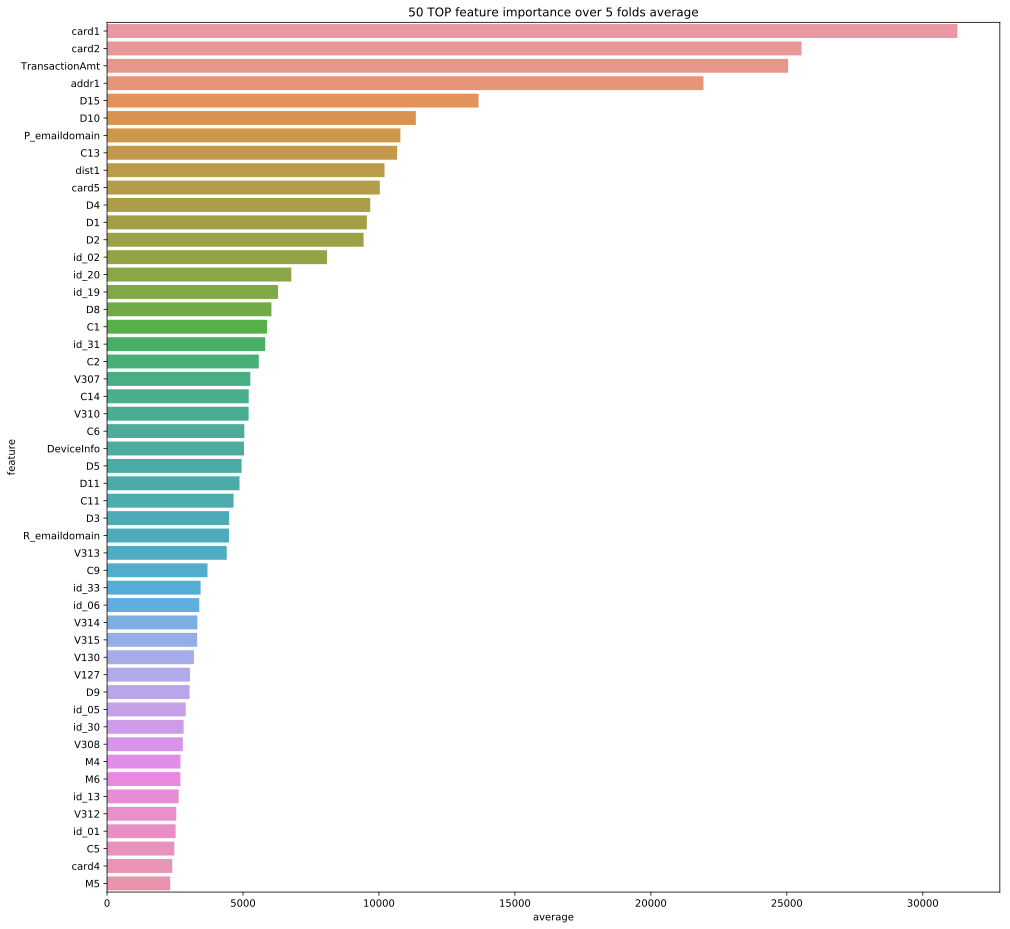

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
#feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns_pic = sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature')
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits))

In [17]:
best_iter = clf.best_iteration

In [18]:
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X_train, y_train)

D:\Selvaria\Anaconda\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.3797454081646243, importance_type='split',
        learning_rate=0.006883242363721497, max_depth=-1, metric='auc',
        min_child_samples=20, min_child_weight=0.03454472573214212,
        min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_boost_round=1238, num_leaves=491,
        objective='binary', random_state=47, reg_alpha=0.3899927210061127,
        reg_lambda=0.6485237330340494, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [ ]:
sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1] #即返回第1列（标签为fraud的概率组成的列）
sample_submission.to_csv('d:/data/Kaggle/IEEE-CIS/simple_lgbm_dropDT&0.9.csv')